LAB 1 SSN MICHAŁ SIENKIEWICZ

In [1]:
# %pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install matplotlib
# %pip install pandas
# %pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
import matplotlib.pyplot as plt

In [5]:
from torch import tensor 
from torchmetrics import Accuracy
import pandas as pd 
from tqdm import tqdm


In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Definicja pierwszej warstwy konwolucyjnej: wejście 3 kanały (RGB), wyjście 32 kanały, rozmiar filtra 3x3, padding=1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # Definicja drugiej warstwy konwolucyjnej: wejście 32 kanały, wyjście 64 kanały, rozmiar filtra 3x3, padding=1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Definicja trzeciej warstwy konwolucyjnej: wejście 64 kanały, wyjście 128 kanały, rozmiar filtra 3x3, padding=1
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # Warstwa dropout1 z prawdopodobieństwem wyzerowania 25% neuronów
        self.dropout1 = nn.Dropout(0.25)
        # Warstwa dropout2 z prawdopodobieństwem wyzerowania 50% neuronów
        self.dropout2 = nn.Dropout(0.5)
        # Warstwa w pełni połączona (fully connected), wejście 128 * 4 * 4 neurony (wynik rozmiaru tensora po ostatniej konwolucji), wyjście 512 neurony
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # Warstwa w pełni połączona (fully connected), wejście 512 neurony, wyjście 10 neurony (liczba klas)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Przekształcenie wejścia przez pierwszą warstwę konwolucyjną, zastosowanie funkcji aktywacji ReLU
        x = nn.functional.relu(self.conv1(x))
        # Redukcja wymiarowości przez operację max-pooling z rozmiarem okna 2x2
        x = nn.functional.max_pool2d(x, 2)
        # Przekształcenie przez drugą warstwę konwolucyjną, zastosowanie funkcji aktywacji ReLU
        x = nn.functional.relu(self.conv2(x))
        # Redukcja wymiarowości przez operację max-pooling z rozmiarem okna 2x2
        x = nn.functional.max_pool2d(x, 2)
        # Przekształcenie przez trzecią warstwę konwolucyjną, zastosowanie funkcji aktywacji ReLU
        x = nn.functional.relu(self.conv3(x))
        # Redukcja wymiarowości przez operację max-pooling z rozmiarem okna 2x2
        x = nn.functional.max_pool2d(x, 2)
        # Wykorzystanie warstwy dropout1
        x = self.dropout1(x)
        # Spłaszczenie tensora do postaci wektora przed podaniem na warstwę w pełni połączoną
        x = torch.flatten(x, 1)
        # Przekształcenie przez warstwę w pełni połączoną, zastosowanie funkcji aktywacji ReLU
        x = nn.functional.relu(self.fc1(x))
        # Wykorzystanie warstwy dropout2
        x = self.dropout2(x)
        # Przekształcenie przez warstwę w pełni połączoną (wyjściową)
        x = self.fc2(x)
        # Zastosowanie funkcji log_softmax dla uzyskania prawdopodobieństw przynależności do klas
        output = nn.functional.log_softmax(x, dim=1)
        return output

In [8]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [9]:
#function to check accuracy
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    model.train()

In [10]:
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

[1, 100] loss: 2.279
[1, 200] loss: 2.079
[1, 300] loss: 1.927
[1, 400] loss: 1.805
[1, 500] loss: 1.721
[1, 600] loss: 1.674
[1, 700] loss: 1.630


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

Accuracy on the test set: 41.73%


ZAD.1.

MNIST

In [12]:
# przygotowanie transformacji dla zestawu danych MNIST (liczby ręcznie pisane)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(((0.5,)),  (0.5,))
])

In [13]:
# pobranie zestawu danych MNIST
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [14]:
#model sieci neuronowej dla MNIST
class NetMNIST(nn.Module):
    def __init__(self):
        super(NetMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.dropout1 = nn.Dropout(0.25) # 0.25 prawdopodobieństwo wyzerowania neruonów
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
       

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc1(x))
        output = nn.functional.log_softmax(x, dim=1)
        return output

Sieć jest niewielka, gdyż zbiór przedstawia stosunkowo czytelnie napisane liczby.
Nawet dodanie warstw dropoutu nie pogorszyło wyników. Biorąc pod uwagę to jak dobre dane są w tym zbiorze, prawdopodobnie dodawanie warstw dropout nie ma większego znaczenia(jest niewiele skrajnych przypadków). 

In [15]:
model = NetMNIST()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [16]:
losses = [] # tablica strat 

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            
            
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            losses += [running_loss / 100]
            running_loss = 0.0

[1, 100] loss: 1.053
[1, 200] loss: 0.263
[1, 300] loss: 0.204
[1, 400] loss: 0.165
[1, 500] loss: 0.159
[1, 600] loss: 0.147
[1, 700] loss: 0.134
[1, 800] loss: 0.122
[1, 900] loss: 0.126
[2, 100] loss: 0.102
[2, 200] loss: 0.106
[2, 300] loss: 0.109
[2, 400] loss: 0.097
[2, 500] loss: 0.100
[2, 600] loss: 0.102
[2, 700] loss: 0.092
[2, 800] loss: 0.082
[2, 900] loss: 0.089
[3, 100] loss: 0.091
[3, 200] loss: 0.090
[3, 300] loss: 0.083
[3, 400] loss: 0.081
[3, 500] loss: 0.073
[3, 600] loss: 0.079
[3, 700] loss: 0.080
[3, 800] loss: 0.077
[3, 900] loss: 0.078
[4, 100] loss: 0.075
[4, 200] loss: 0.076
[4, 300] loss: 0.064
[4, 400] loss: 0.078
[4, 500] loss: 0.068
[4, 600] loss: 0.073
[4, 700] loss: 0.077
[4, 800] loss: 0.072
[4, 900] loss: 0.069
[5, 100] loss: 0.069
[5, 200] loss: 0.063
[5, 300] loss: 0.071
[5, 400] loss: 0.069
[5, 500] loss: 0.070
[5, 600] loss: 0.057
[5, 700] loss: 0.065
[5, 800] loss: 0.068
[5, 900] loss: 0.069


In [17]:
from torchmetrics.classification import MulticlassAccuracy
mca = MulticlassAccuracy(num_classes=10, average=None)

In [18]:
from torchmetrics.classification import MulticlassRecall
mcr = MulticlassRecall(num_classes=10, average=None)

In [19]:
mca_multi = MulticlassAccuracy(num_classes=10, average="micro")
mcr_multi = MulticlassRecall(num_classes=10, average="micro")


In [20]:
from torchmetrics.classification import MulticlassConfusionMatrix
mcm = MulticlassConfusionMatrix(num_classes=10)

In [21]:
correct = 0
total = 0
with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        mca.update(predicted, labels)
        mcr.update(predicted, labels)
        mcm.update(predicted, labels)

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

Accuracy on the test set: 98.22%


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

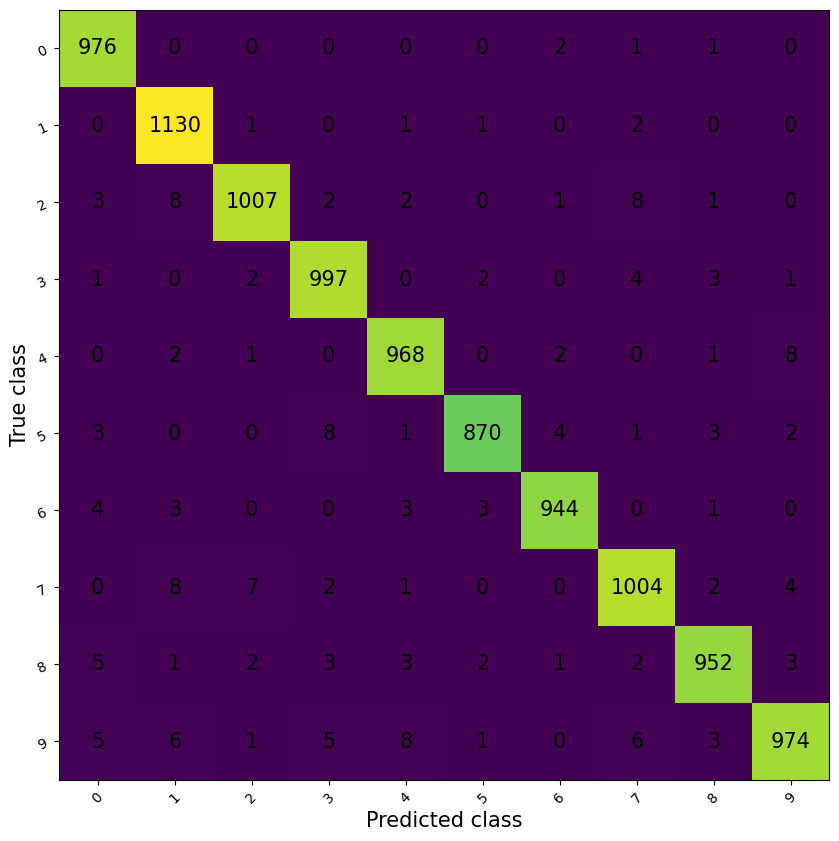

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

mcm.plot(ax=fig.gca())

Z macierzy pomyłek można odczytać, że największe problemy model miał z rozpoznawaniem 8 i 9. Liczba 9 była np. mylona z liczbą 4, co jest zdecydowanie możliwe.

(None, <Axes: ylabel='MulticlassAccuracy'>)

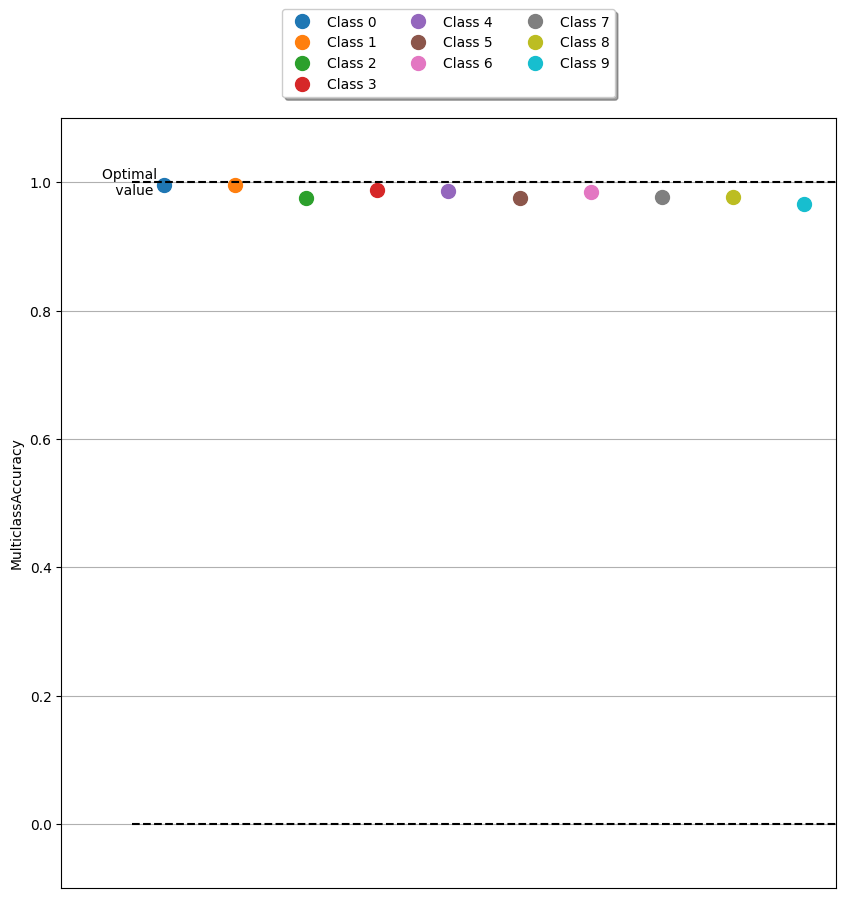

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

mca.plot(ax=ax)


Powyższa metryka przedstawia wysoką skuteczność wytrenowanego modelu.

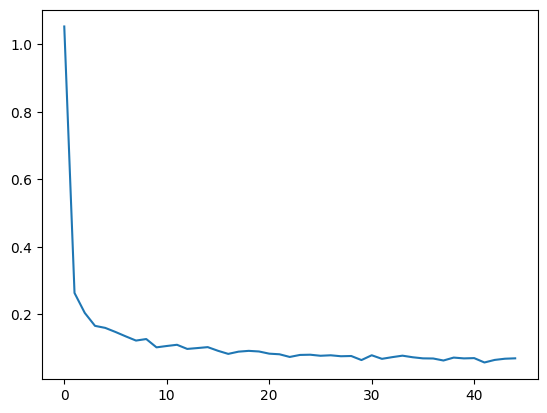

In [24]:

plt.plot(losses)

Z wykresu można wywnioskować, że uczenie modelu można było zakończyć praktycznie 2 razy szybciej, gdyż model poczynił bardzo niewielki postęp w minmalizacji strat.

(None, <Axes: ylabel='MulticlassRecall'>)

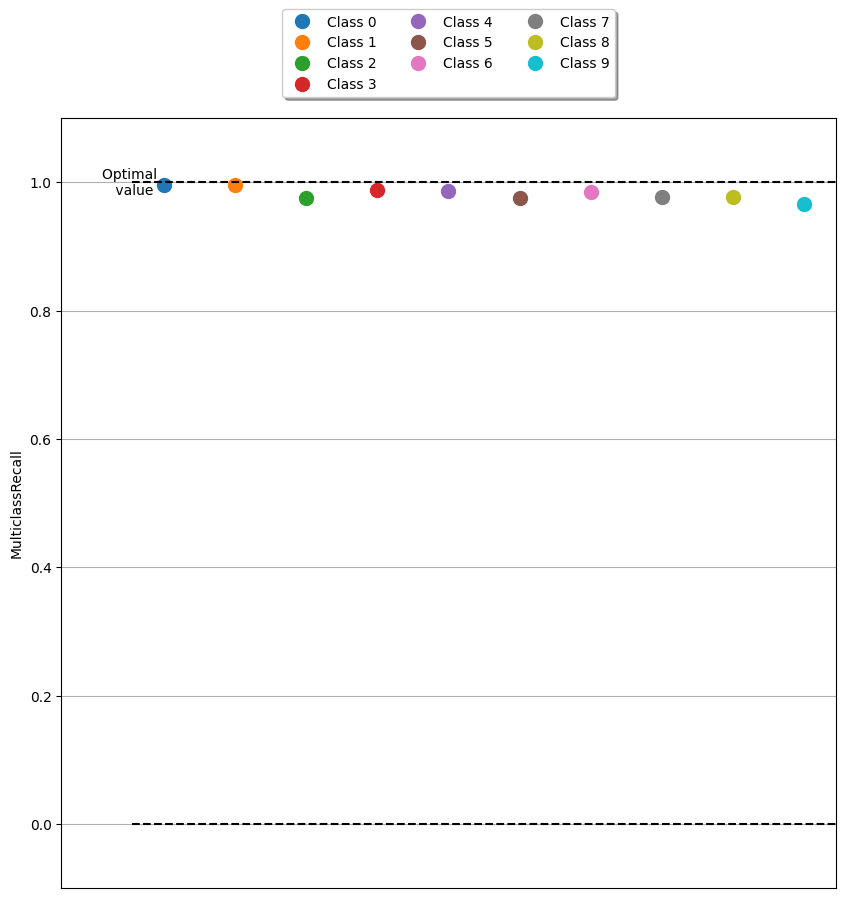

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
mcr.plot(ax=ax)

In [26]:

df = pd.DataFrame()

mca_multi.compute().item()

correct = 0
total = 0
for i in range(5):
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            mca.update(predicted, labels)
            mcr.update(predicted, labels)
            mca_multi.update(predicted, labels)
            mcr_multi.update(predicted, labels)

    df = pd.concat([df, pd.DataFrame({'accuracy': [100 * correct / total],  'mca_multi': [mca_multi.compute().item()], 'mcr_multi': [mcr_multi.compute().item()]})])
    

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")




/home/michaelangelo/mag_sem1/annlabs/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy on the test set: 98.04%


In [27]:
display(df)

,accuracy,mca_multi,mcr_multi
0,98.110000,0.981100,0.981100
0,98.115000,0.981150,0.981150
0,98.073333,0.980733,0.980733
0,98.085000,0.980850,0.980850
0,98.040000,0.980400,0.980400


Model jest dobrze wytrenowany na zbiorze danych. Wahania metryk pomiędzy kolejnymi próbami testowymi na tym samym zbiorze testowym są niewielkie, co również potwierdza deterministyczność wwytrenowanego modelu. 

FashionMNIST

In [28]:
torch.cuda.is_available()

True

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
#fashionMNIST dataset
fashion_train_transform = transforms.Compose([
    # transforms.RandomCrop(28, padding=4), 
    # transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


Dodatkowe transformacje w zbiorze treningowym również zostały wykluczone, gdyż mogę się pojawić przypadki, gdzie jedna część garderoby po opercji przypomina drugą część garderoby. Np. Random Crop powoduje, że pół bluzki przypomina buta.


In [31]:
fashion_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=fashion_train_transform)
fashion_trainloader = torch.utils.data.DataLoader(fashion_trainset, batch_size=64, shuffle=True)
fashion_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=fashion_test_transform)
fashion_testloader = torch.utils.data.DataLoader(fashion_testset, batch_size=64, shuffle=False)


In [32]:
print(fashion_trainset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [33]:
class FashionNet(nn.Module):
    def __init__(self):
        #28x28 -> 14x14 -> 7x7 
        super(FashionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.dropout1 = nn.Dropout(0.2) # 0.2 prawdopodobieństwo wyzerowania neruonów
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

Sieć została powiększona o dodatkowe warstwy, gdyż zbiór danych z częściami garderoby jest bardziej skomplikowany od zbioru liczb.
koszula może przypominać cienki swetr, swetr może przypominać kurtkę, a kurtka może przypominać sukienkę.

In [34]:
fashion_model = FashionNet()
fashion_model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(fashion_model.parameters(), lr=0.01, momentum=0.9, weight_decay=9e-4)

In [57]:
losses = [] # tablica strat

for epoch in range(5):
    running_loss = 0.0
    pbar = tqdm(enumerate(fashion_trainloader), total=len(fashion_trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        optimizer.zero_grad()
        outputs = fashion_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_description(f"Epoch[{epoch + 1}, 5] loss: {running_loss /(i+1):.3f}")
        if i % 100 == 99:
            losses += [running_loss / 100]
            running_loss = 0.0

Epoch[5, 5] loss: 0.011: 100%|██████████| 938/938 [00:08<00:00, 104.63it/s]


In [61]:
mca_fashion = MulticlassAccuracy(num_classes=10, average=None).to(device)
mcr_fashion = MulticlassRecall(num_classes=10, average=None).to(device)
mca_multi_fashion = MulticlassAccuracy(num_classes=10, average="micro").to(device)
mcr_multi_fashion = MulticlassRecall(num_classes=10, average="micro").to(device)
mcm_fashion = MulticlassConfusionMatrix(num_classes=10).to(device)


In [62]:

df_fashion = pd.DataFrame()

correct = 0
total = 0
for i in range(5):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in fashion_testloader:
            images, labels = data
            images = images.to(device=device)
            labels = labels.to(device=device)
            outputs = fashion_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            mca_fashion.update(predicted, labels)
            mcr_fashion.update(predicted, labels)
            if i == 4:
                mcm_fashion.update(predicted, labels)
                mca_multi_fashion.update(predicted, labels)
                mcr_multi_fashion.update(predicted, labels)

    df_fashion = pd.concat([df_fashion, pd.DataFrame({'fashion_accuracy': [100 * correct / total],  'fashion_mca_multi': [mca_multi_fashion.compute().item()], 'fashion_mcr_multi': [mcr_multi_fashion.compute().item()]})])
    

    print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

/home/michaelangelo/mag_sem1/annlabs/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/michaelangelo/mag_sem1/annlabs/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassRecall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy on the test set: 88.57%
Accuracy on the test set: 88.69%
Accuracy on the test set: 89.00%
Accuracy on the test set: 89.00%
Accuracy on the test set: 88.78%


In [64]:
display(df_fashion)

,fashion_accuracy,fashion_mca_multi,fashion_mcr_multi
0,88.57,0.0000,0.0000
0,88.69,0.0000,0.0000
0,89.00,0.0000,0.0000
0,89.00,0.0000,0.0000
0,88.78,0.8878,0.8878


[Text(0, 0, 'T-shirt/top'),
 Text(0, 1, 'Trouser'),
 Text(0, 2, 'Pullover'),
 Text(0, 3, 'Dress'),
 Text(0, 4, 'Coat'),
 Text(0, 5, 'Sandal'),
 Text(0, 6, 'Shirt'),
 Text(0, 7, 'Sneaker'),
 Text(0, 8, 'Bag'),
 Text(0, 9, 'Ankle boot')]

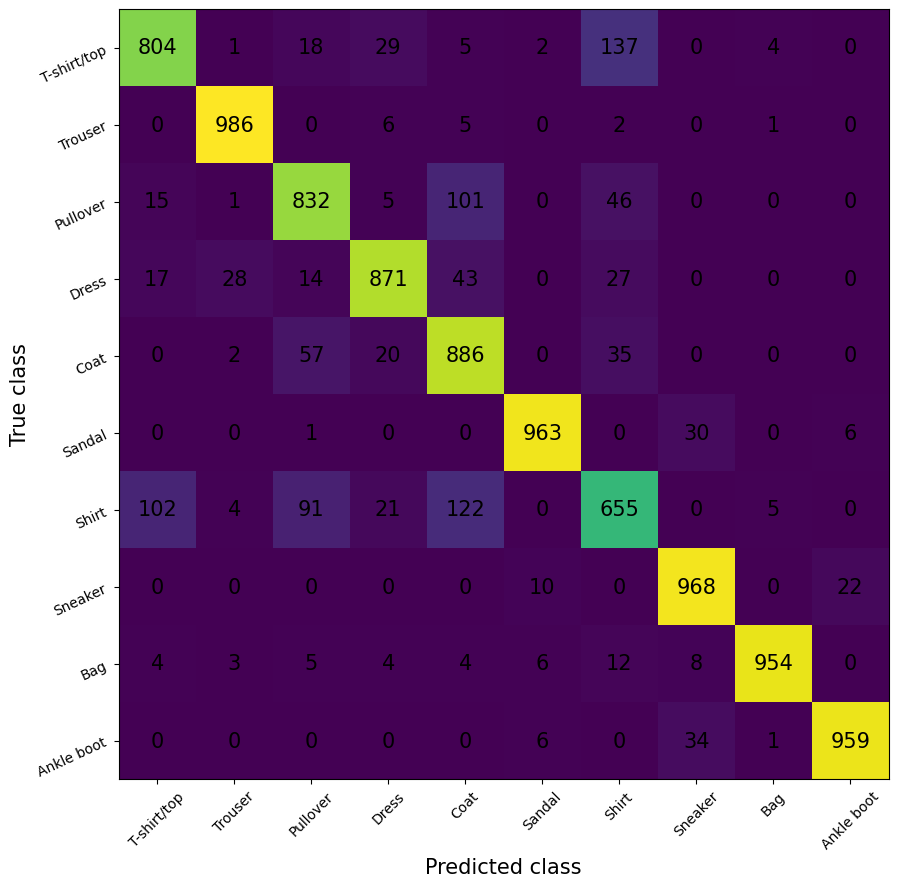

In [65]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

mcm_fashion.plot(ax=fig.gca())
ax.set_xticklabels(fashion_trainset.classes)
ax.set_yticklabels(fashion_trainset.classes)

Najczęściej mylonymi elementami garderoby są koszule i koszulki, a poniższa metryka przedstawia fakt, że koszule są elementami garderoby najczęściej mylonymi, gdyż ich skuteczność rozpoznawania jest najmniejsza.

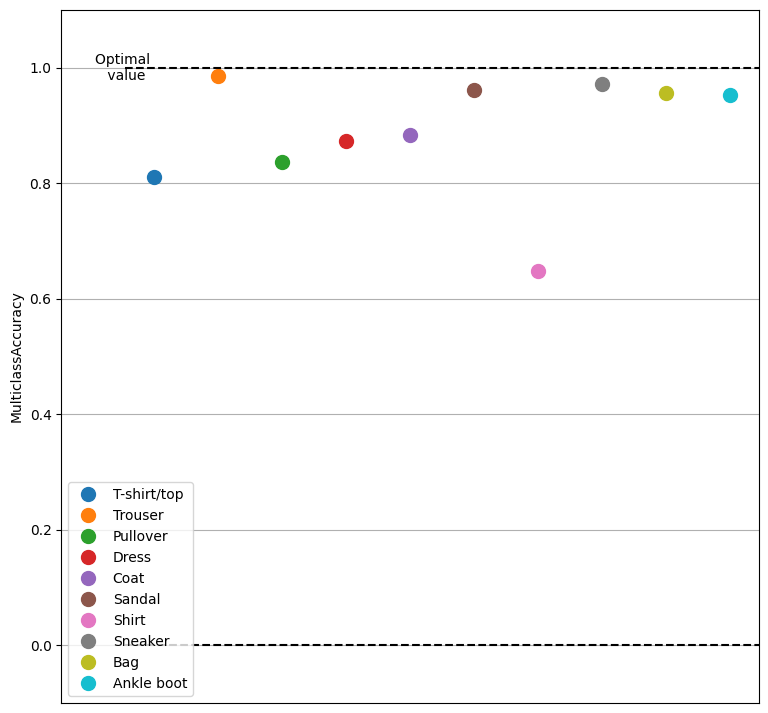

In [66]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()

mca_fashion.plot(ax=ax)
ax.legend(fashion_trainset.classes)

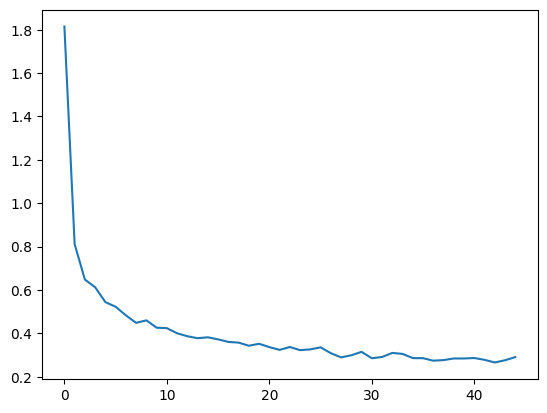

In [42]:
plt.plot(losses)

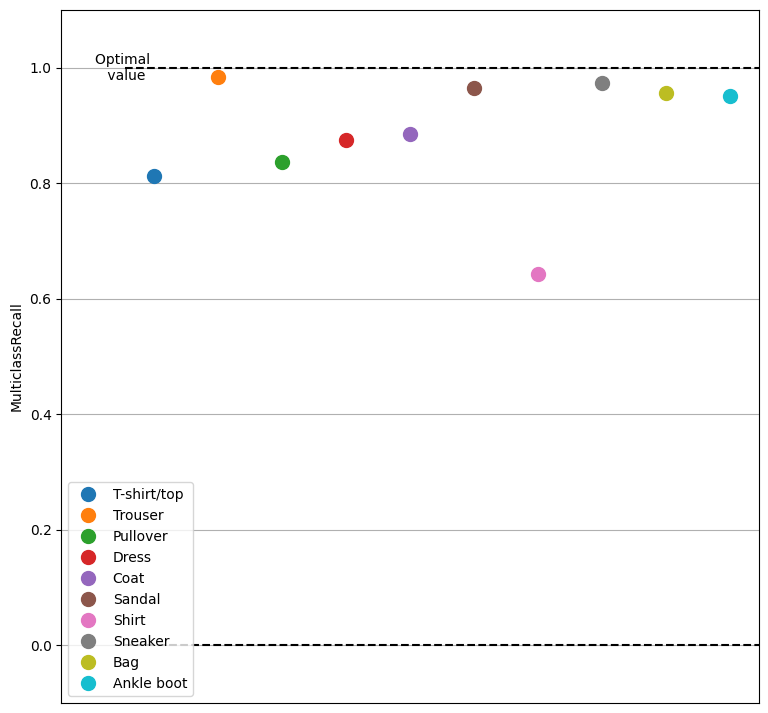

In [43]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
mcr_fashion.plot(ax=ax)
ax.legend(fashion_trainset.classes)

CIFAR

In [44]:
fashion_train_transform = transforms.Compose([
    # transforms.RandomCrop(28, padding=4), 
    # transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
])

fashion_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
])

Dodatkowe transformacje również nie zostały dodane do tego zbioru, gdyż jest to zbiór posiadający bardzo dużo różnych zdjęć z różnych dziedzin.

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [46]:
cifar_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=fashion_train_transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True)
cifar_testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=fashion_test_transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [47]:
print(cifar_trainset.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [48]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        self.bnorm1 = nn.BatchNorm2d(32)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.bnorm4 = nn.BatchNorm2d(256)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 100)
        

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.bnorm1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = self.bnorm2(x)
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = self.bnorm3(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv4(x))
        x = self.bnorm4(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        x = self.dropout4(x)
        x = self.fc4(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

Aby sieć miała jakikolwiek wynik musiała ona zostać znacznie rozbudowania. Na konfiguracji podobnej ze zbiorem elementów garderoby, CIFAR100 osiągał dokładność ~10%. Znaczne rozbudowanie sieci poleprzyszło wyniki około 4,5 razy.

In [49]:
cifar_model = CifarNet()
cifar_model.cuda()
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(cifar_model.parameters(), lr=0.01, momentum=0.9, weight_decay=9e-4)
    

In [67]:
cifar_losses = [] 

epochs = 40
for epoch in  range(epochs):
    running_loss = 0.0
    pbar = tqdm(enumerate(cifar_trainloader), total=len(cifar_trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        optimizer.zero_grad()
        outputs = cifar_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f"Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / (i + 1):.3f}")
        if i % 100 == 99:
            losses += [running_loss / 100]
            running_loss = 0.0


Epoch [40/40] Loss: 0.156: 100%|██████████| 782/782 [00:06<00:00, 114.78it/s]


In [51]:
mca_cifar = MulticlassAccuracy(num_classes=100, average=None).to(device)
mcr_cifar = MulticlassRecall(num_classes=100, average=None).to(device)
mca_multi_cifar = MulticlassAccuracy(num_classes=100, average="micro").to(device)
mcr_multi_cifar = MulticlassRecall(num_classes=100, average="micro").to(device)
mcm_cifar = MulticlassConfusionMatrix(num_classes=100).to(device)


In [52]:
df_cifar = pd.DataFrame()

correct = 0
total = 0
for i in range(5):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in cifar_testloader:
            images, labels = data
            images = images.to(device=device)
            labels = labels.to(device=device)
            outputs = cifar_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            mca_cifar.update(predicted, labels)
            mcr_cifar.update(predicted, labels)
            if i == 4:
                mcm_cifar.update(predicted, labels)
                mca_multi_cifar.update(predicted, labels)
                mcr_multi_cifar.update(predicted, labels)

    df_fashion = pd.concat([df_fashion, pd.DataFrame({'fashion_accuracy': [100 * correct / total],  'fashion_mca_multi': [mca_multi_fashion.compute().item()], 'fashion_mcr_multi': [mcr_multi_fashion.compute().item()]})])
    

    print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

Accuracy on the test set: 44.98%
Accuracy on the test set: 43.94%
Accuracy on the test set: 43.82%
Accuracy on the test set: 43.77%
Accuracy on the test set: 44.21%


(<Figure size 3000x3000 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

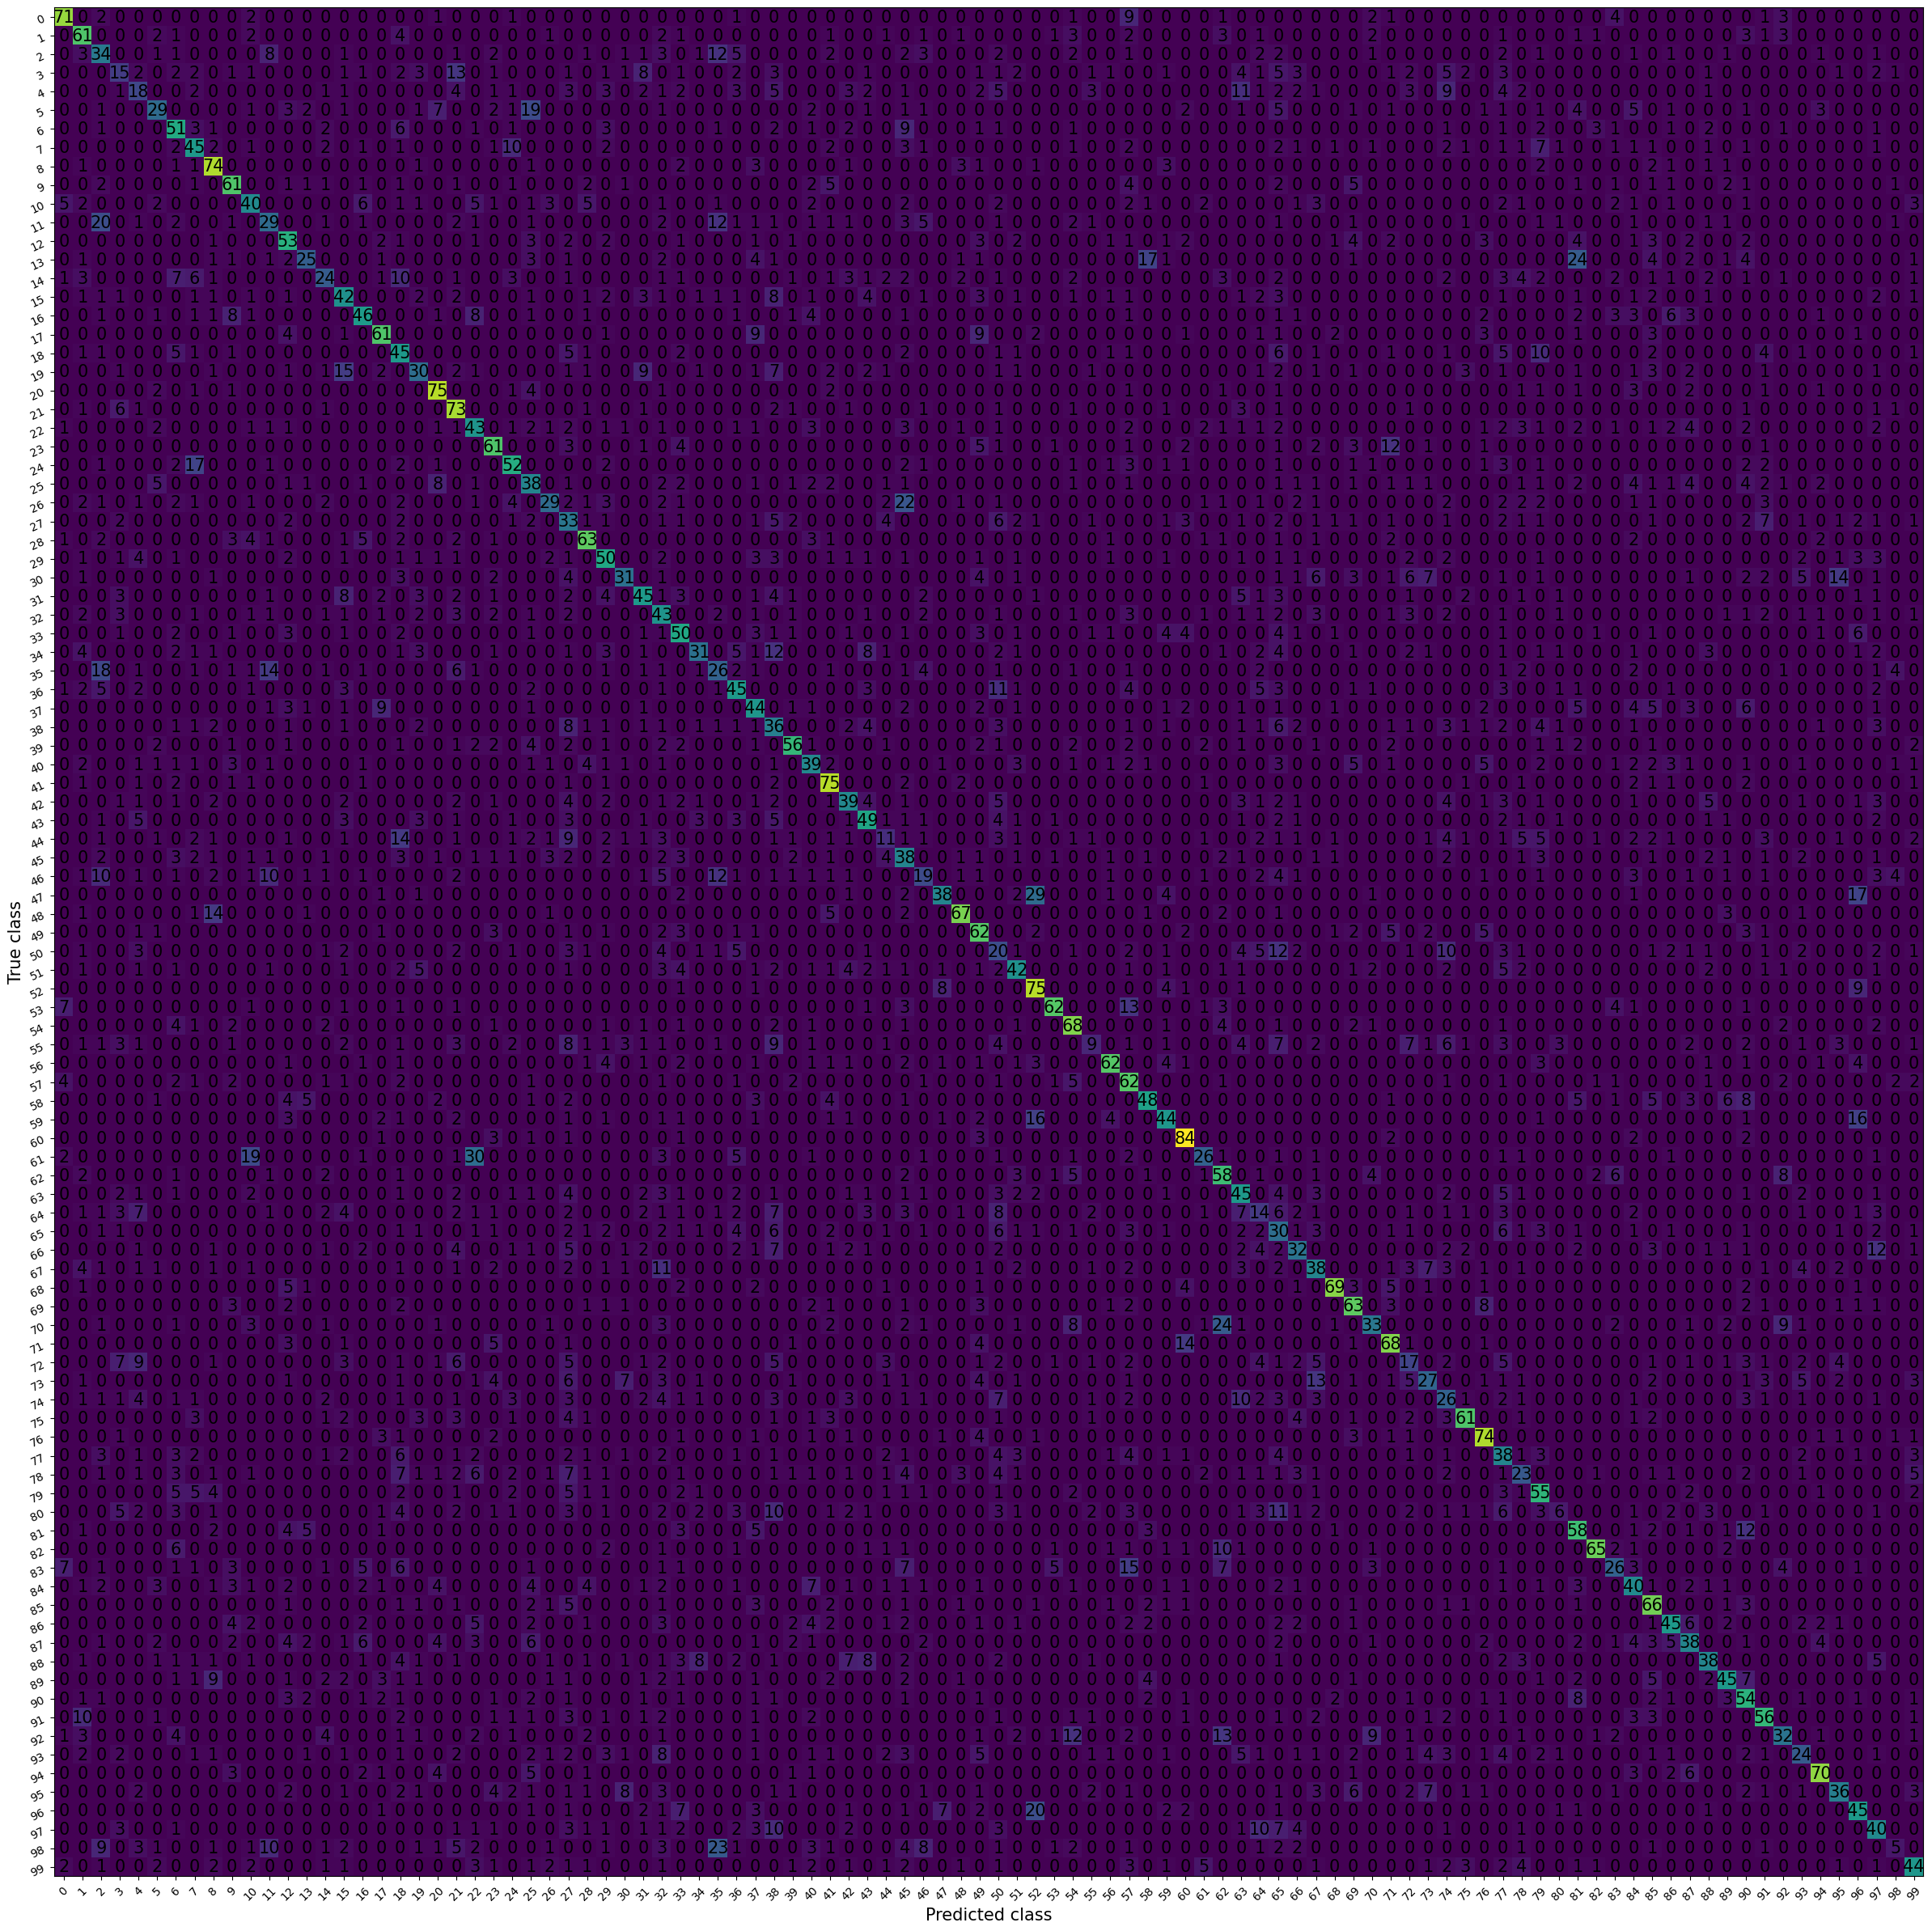

In [53]:
fig = plt.figure(figsize=(30, 30))
ax = fig.gca()

mcm_cifar.plot(ax=fig.gca())

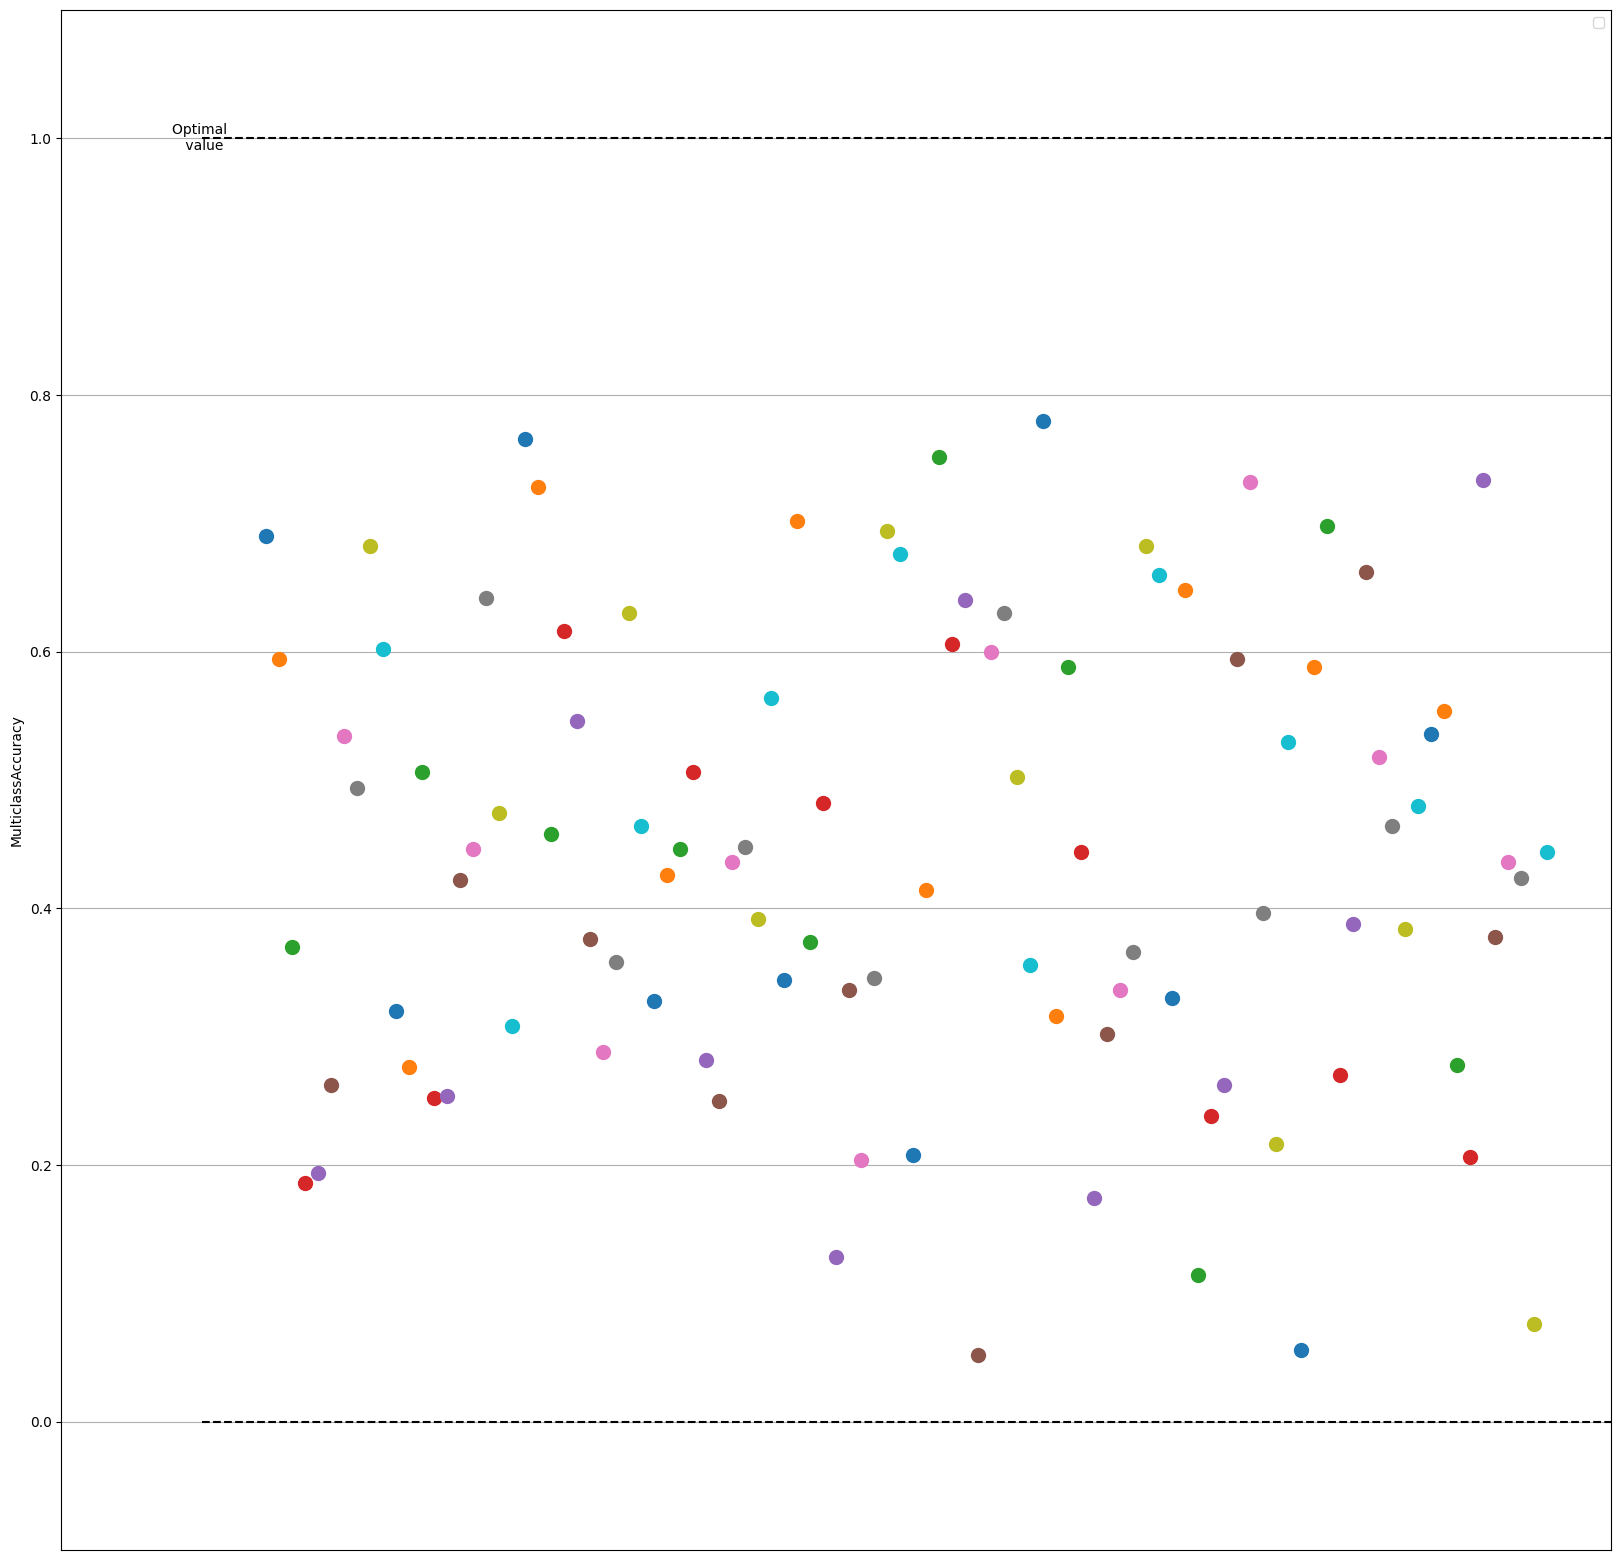

In [54]:
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
mca_cifar.plot(ax=ax)
ax.legend([])

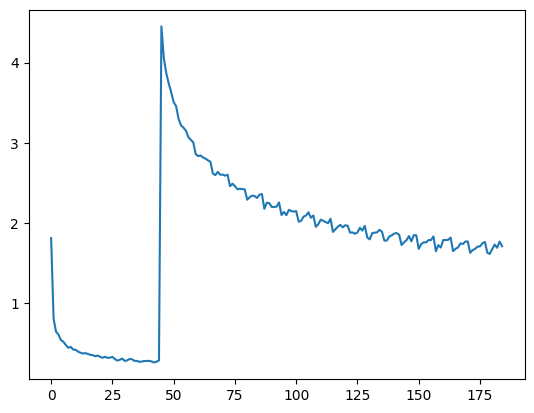

In [55]:
plt.plot(losses)

Metryka straty przedstawiająca początkowy błąd w stracie przy uczeniu modelu.  

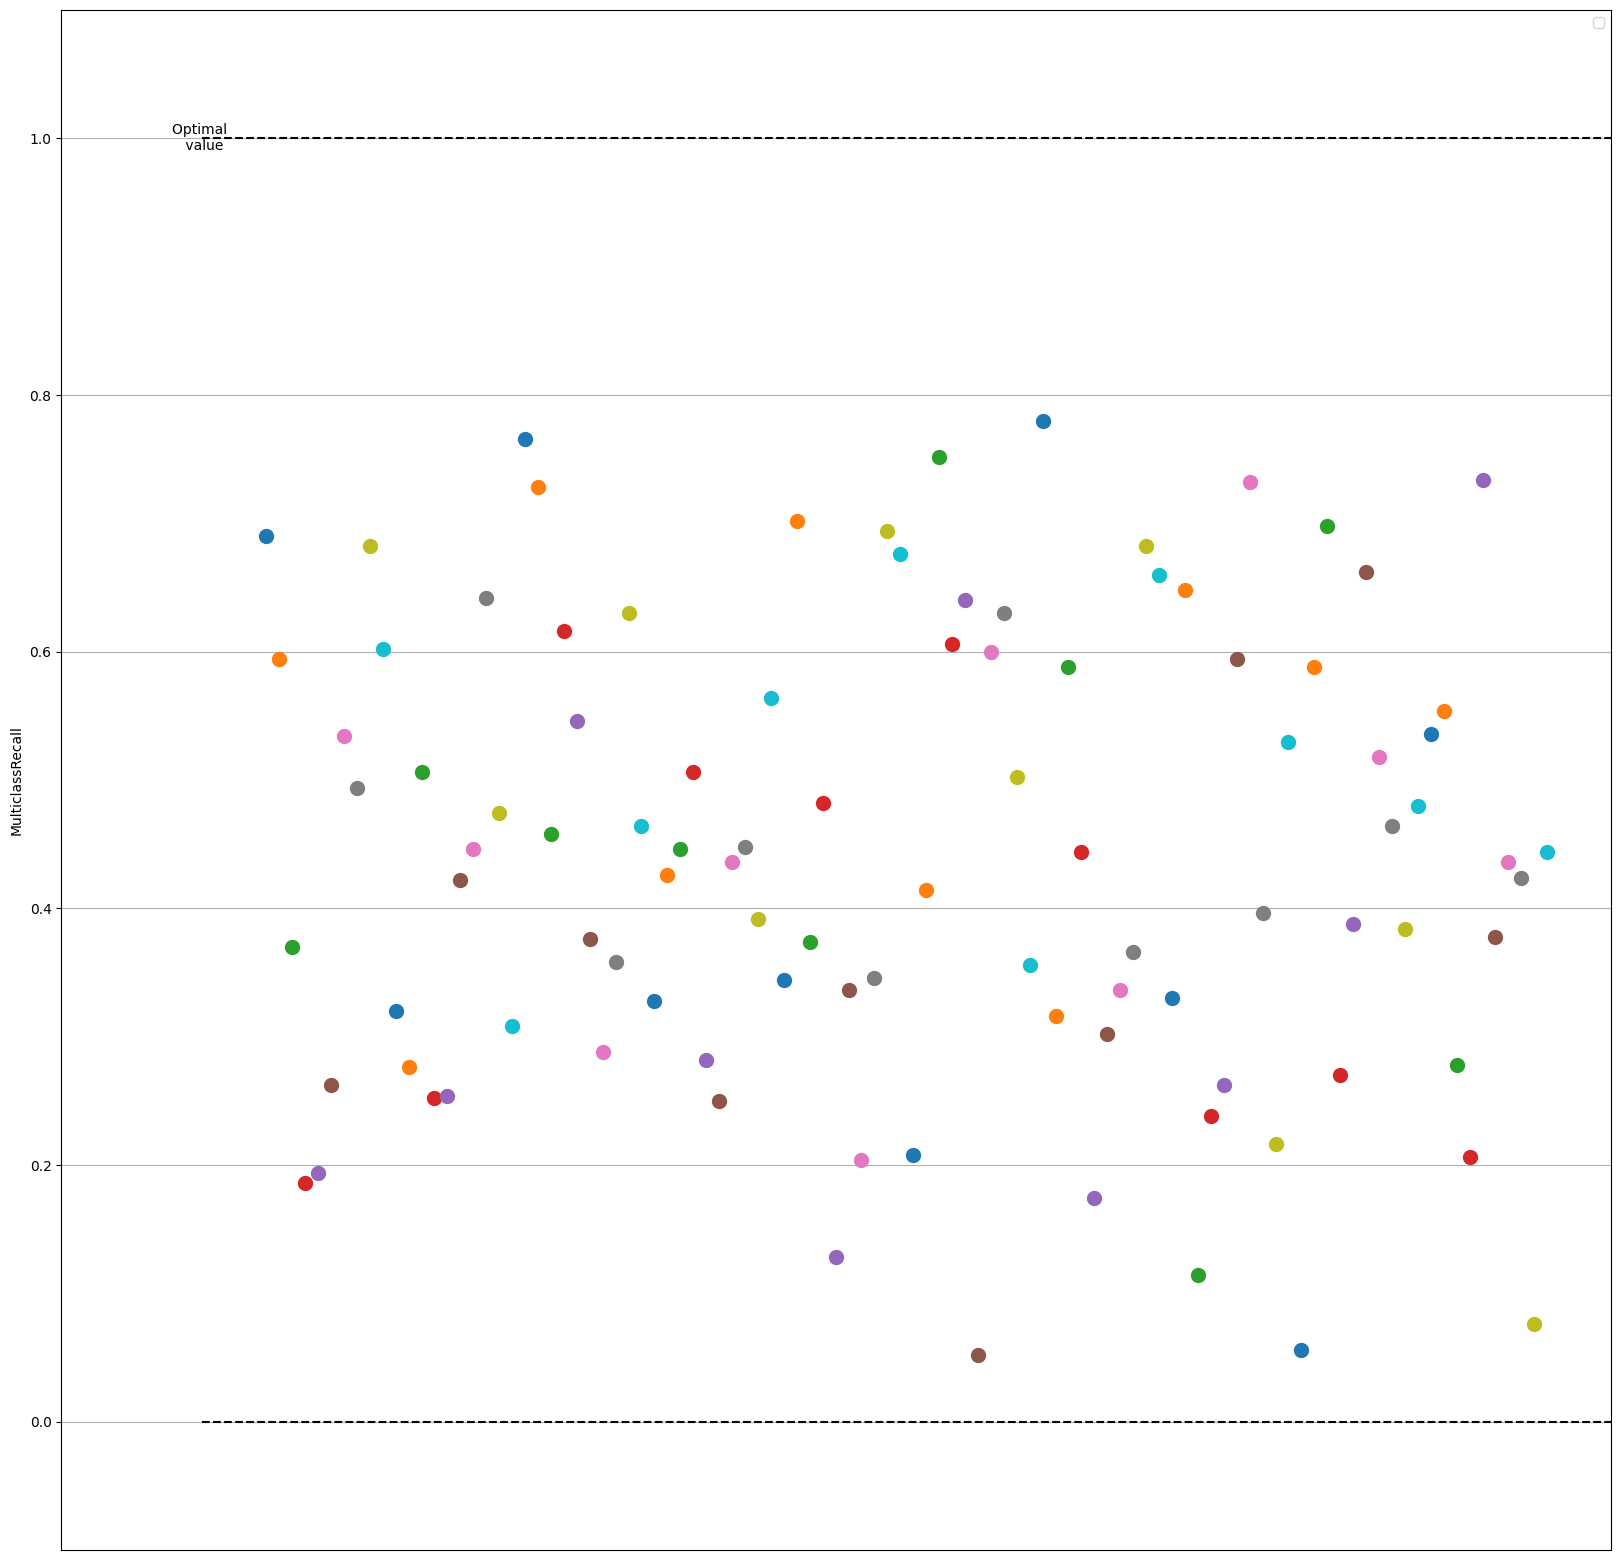

In [56]:
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
mcr_cifar.plot(ax=ax)
ax.legend([])

Większość metryk przy tym zbiorze staje się nieczytelna, gdyż posiada on 100 różnych kartegorii. 